In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 14 14:16:04 2020

@author: thomas
"""

#MODULES
import os,sys
import re
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d
%matplotlib notebook
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator,AutoMinorLocator)
from scipy.signal import savgol_filter
import pathlib
from matplotlib import animation
from IPython.display import display, Image, HTML

mpl.rcParams['axes.linewidth'] = 1.5 #set the value globally

In [3]:
#CONSTANTS
cwd_PYTHON = os.getcwd()
PERIOD = 0.1
DT = 5.0e-3
RADIUSLARGE = 0.002
RADIUSSMALL = 0.001
FREQUENCY   = 10.0  

#Lists
#RLength
VReList=['0.5','0.6','0.7','0.8','0.9','1.0','2.0','3.0','4.0','5.0','5.5','6.0','6.5','7.0','7.5','10.0','12.5','15.0',
        '17.5','20.0','25.0','30.0','35.0','40.0','50.0']
OReList=['6.5','7.0','7.5','10.0','12.5','15.0','17.5','20.0','25.0','30.0']
HBReList=['0.5','1.0','2.0','3.0','4.0','5.0','7.5','10.0','12.5','15.0',
        '17.5','20.0']#,'25.0','30.0','35.0','40.0','50.0','60.0']
SFReList=['0.5','0.6','0.7','0.8','0.9','1.0','2.0','3.0','4.0','5.0','5.5','6.0','6.5','7.0','7.5']
VData = []
OData = []
HBData = []
SFData = []

In [4]:
%matplotlib inline
from scipy import stats
csfont = {'fontname':'Times New Roman'}

def GetStats(data, config):
    #Get mean and std of 
    # Theta_BW, H_BW, and Vcomb
    #Remove any outliers (H_BW jump)
    data['zscore'] = np.abs(stats.zscore(data['Hmag']))
    data = data[data['zscore'] < 3]
    data = data.reset_index(drop=True)
    #Means and stds
    theta_avg = data['Theta'].mean()
    theta_std = data['Theta'].std()
    HBW_avg   = data['Hmag'].mean()
    HBW_std   = data['Hmag'].std()
    #Hx and Hy
    Hx_avg   = data['Hx'].mean()
    Hx_std   = data['Hx'].std()
    Hy_avg   = data['Hy'].mean()
    Hy_std   = data['Hy'].std()
    if(config == 'O'):
        omega_avg = data['wAVG'].mean()
        omega_std = data['wAVG'].std()
    else:
        Vcomb_avg = data['v_comb'].mean()
        Vcomb_std = data['v_comb'].std()
        
        
    if(config == 'O'):
        return (theta_avg, theta_std, HBW_avg, HBW_std, Hx_avg, Hx_std, Hy_avg, Hy_std, omega_avg, omega_std)
    else:
        return (theta_avg, theta_std, HBW_avg, HBW_std, Hx_avg, Hx_std, Hy_avg, Hy_std, Vcomb_avg, Vcomb_std)

def LabelSubplots_Re(ax,config):
    csfont = {'fontname':'Times New Roman'}
    ax[0].set_title(r'%s: $\theta_{bw}$ vs. Re: 2$\sigma$'%config,fontsize=15,**csfont)
    ax[0].set_xlabel(r'Re',fontsize=12,**csfont)
    ax[0].set_ylabel(r'$\theta_{bw}$',fontsize=12,**csfont)
    ax[1].set_title(r'$H_{bw}$ vs. Re: 2$\sigma$',fontsize=15,**csfont)
    ax[1].set_xlabel(r'Re',fontsize=12,**csfont)
    ax[1].set_ylabel(r'$H_{bw}$ ($\delta$)',fontsize=12,**csfont)
    #ax[1].set_ylabel(r'$H_{bw}$ (R)',fontsize=12,**csfont)
    ax[2].set_xlabel(r'Re',fontsize=12,**csfont)
    ax[2].set_title(r'v$_{comb}$ vs. Re: 2$\sigma$',fontsize=15,**csfont)
    ax[2].set_ylabel(r'v$_{comb}/Rf$',fontsize=12,**csfont)
    return ax

def PlotMonitoredParameters(ax,Re,thetaBW,HBW,Vcomb,color):
    ax[0].errorbar(Re, thetaBW[:len(Re),0], yerr=2.0*thetaBW[:len(Re),1],c=color)
    ax[0].scatter(Re, thetaBW[:len(Re),0],c=color,s=12)
    ax[1].errorbar(Re, HBW[:len(Re),0], yerr=2.0*HBW[:len(Re),1],c=color)
    ax[1].scatter(Re, HBW[:len(Re),0],c=color,s=12)
    ax[2].errorbar(Re, Vcomb[:len(Re),0], yerr=2.0*Vcomb[:len(Re),1],c=color)
    ax[2].scatter(Re, Vcomb[:len(Re),0],c=color,s=12)
    return ax

#V-Shape (V)
VData = pd.read_csv(cwd_PYTHON+'/VData.csv',delimiter=' ')

#Construct time_ES list
time_ES = [2.5,10.0,10.0,8.5,8.0,7.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.5,3.0,3.0,2.5,2.5,2.5,2.5,2.0,2.0,2.0,2.0,2.0]
#Given the time_ES (time the end state begins), calculate the mean and std dev of the following parameters
#theta_BW, H_BW, v_comb for each Re
#Save them in np arrays
#Plot parameters vs Re
    
#Arrays (0 = mean, 1 = std dev)
thetaBW_V = np.zeros((25,2))
HBW_V     = np.zeros((25,2))
Hx_V      = np.zeros((25,2))
Hy_V      = np.zeros((25,2))
Vcomb_V   = np.zeros((25,2))
theta2_V  = np.zeros((2,2))
HBW2_V    = np.zeros((2,2))
Hx2_V     = np.zeros((2,2))
Hy2_V     = np.zeros((2,2))
Vcomb2_V  = np.zeros((2,2))

for idx in range(len(VReList)):
    Re = float(VReList[idx])
    ReData = VData[VData['Re'] == Re].copy()
    ReData = ReData.reset_index(drop=True)
    for jdx in range(len(ReData['time'])):
        if(ReData.loc[jdx,'Theta'] <= 90.0):
            ReData.loc[jdx,'Theta'] *= -1.0
        else:
            ReData.loc[jdx,'Theta'] = 360.0 - ReData.loc[jdx,'Theta']
    if(Re <= 35.0):
        ReData = ReData[ReData['time'] >= 10.0].copy()
        if(Re == 35.0):
            ReData = ReData[ReData['time'] <= 18.0].copy()
        ReData = ReData.reset_index(drop=True)
        #Means and stds
        thetaBW_V[idx,0], thetaBW_V[idx,1], HBW_V[idx,0], HBW_V[idx,1], Hx_V[idx,0], Hx_V[idx,1], Hy_V[idx,0], Hy_V[idx,1], Vcomb_V[idx,0], Vcomb_V[idx,1] = GetStats(ReData,'V')
        
    elif(Re == 40.0):
        ReData1 = ReData[ReData['time'] >= 8.0].copy()
        ReData1 = ReData1[ReData1['time'] <= 9.0].copy()
        ReData2 = ReData[ReData['time'] >= 12.5].copy()
        ReData2 = ReData2[ReData2['time'] <= 13.5].copy()
        ReData1 = ReData1.reset_index(drop=True)
        ReData2 = ReData2.reset_index(drop=True)
        #Means and stds
        thetaBW_V[idx,0], thetaBW_V[idx,1], HBW_V[idx,0], HBW_V[idx,1], Hx_V[idx,0], Hx_V[idx,1], Hy_V[idx,0], Hy_V[idx,1], Vcomb_V[idx,0], Vcomb_V[idx,1] = GetStats(ReData1,'V')
        theta2_V[0,0], theta2_V[0,1], HBW2_V[0,0], HBW2_V[0,1], Hx2_V[0,0], Hx2_V[0,1], Hy2_V[0,0], Hy2_V[0,1], Vcomb2_V[0,0], Vcomb2_V[0,1] = GetStats(ReData2,'V')
        print(theta2_V[0,0])
        
    elif(Re == 50.0):
        ReData1 = ReData[ReData['time'] >= 12.5].copy()
        ReData1 = ReData1[ReData1['time'] <= 17.5].copy()
        ReData2 = ReData[ReData['time'] >= 4.5].copy()
        ReData2 = ReData2[ReData2['time'] <= 8.5].copy()
        ReData1 = ReData1.reset_index(drop=True)
        ReData2 = ReData2.reset_index(drop=True)
        #Means and stds
        thetaBW_V[idx,0], thetaBW_V[idx,1], HBW_V[idx,0], HBW_V[idx,1], Hx_V[idx,0], Hx_V[idx,1], Hy_V[idx,0], Hy_V[idx,1], Vcomb_V[idx,0], Vcomb_V[idx,1] = GetStats(ReData1, 'V')
        theta2_V[1,0], theta2_V[1,1], HBW2_V[1,0], HBW2_V[1,1], Hx2_V[1,0], Hx2_V[1,1], Hy2_V[1,0], Hy2_V[1,1], Vcomb2_V[1,0], Vcomb2_V[1,1] = GetStats(ReData2, 'V')

    else:
        print('Re = 60 has no stable end state: Collision') 
        
    if(float(VReList[idx]) < 35.0):
        Vcomb_V[idx,0] *= -1.0
        
    
#Single File (SF)
SFData = pd.read_csv(cwd_PYTHON+'/SFData.csv',delimiter=' ')
nRe = 15
time_ES = [2.5 for a in range(nRe)]

thetaBW_SF = np.zeros((nRe,2))
HBW_SF     = np.zeros((nRe,2))
Hx_SF      = np.zeros((nRe,2))
Hy_SF      = np.zeros((nRe,2))
Vcomb_SF   = np.zeros((nRe,2))

for idx in range(nRe):
    Re = float(SFReList[idx])
    ReData = SFData[SFData['Re'] == Re].copy()
    ReData = ReData.reset_index(drop=True)
    #Calculate Delta for each Re
    delta = np.sqrt(RADIUSSMALL*RADIUSLARGE*0.8*0.8/Re)
    ReData = ReData[ReData['time'] >= time_ES[idx]]
    ReData = ReData.reset_index(drop=True)
    for jdx in range(len(ReData['time'])):
        if(ReData.loc[jdx,'Theta'] > 180.0):
            ReData.loc[jdx,'Theta'] = ReData.loc[jdx,'Theta'] - 360.0
    #Means and stds
    thetaBW_SF[idx,0], thetaBW_SF[idx,1], HBW_SF[idx,0], HBW_SF[idx,1], Hx_SF[idx,0], Hx_SF[idx,1], Hy_SF[idx,0], Hy_SF[idx,1], Vcomb_SF[idx,0], Vcomb_SF[idx,1] = GetStats(ReData,'SF')
    
Vcomb_SF[:,0] = -1.0*Vcomb_SF[:,0]

#Orbit (O)
OData = pd.read_csv(cwd_PYTHON+'/OData.csv',delimiter=' ')
#Construct time_ES list

time_ES = [12.0,15.0,6.0,5.0,4.0,4.0,3.5,3.5,3.0,3.0,3.0]
nRe = 10

#Arrays (0 = mean, 1 = std dev)
thetaBW_O = np.zeros((nRe,2))
HBW_O     = np.zeros((nRe,2))
Hx_O      = np.zeros((nRe,2))
Hy_O      = np.zeros((nRe,2))
omega_O   = np.zeros((nRe,2))

for idx in range(nRe):
    Re = float(OReList[idx])
    ReData = OData[OData['Re'] == Re].copy()
    ReData = ReData[ReData['time'] >= time_ES[idx]].copy()
    ReData = ReData.reset_index(drop=True)
    ReData['Theta'] = 360.0 - ReData['Theta']
    #Calculate Delta for each Re
    #delta = np.sqrt(RADIUSSMALL*RADIUSLARGE*0.8*0.8/Re)
    thetaBW_O[idx,0], thetaBW_O[idx,1], HBW_O[idx,0], HBW_O[idx,1], Hx_O[idx,0], Hx_O[idx,1], Hy_O[idx,0], Hy_O[idx,1],omega_O[idx,0], omega_O[idx,1] = GetStats(ReData,'O')

#Headbutt (HB)
HBData = pd.read_csv(cwd_PYTHON+'/HBData.csv',delimiter=' ')
nRe = 12
time_ES = [2.5 for a in range(nRe)]

thetaBW_HB = np.zeros((nRe,2))
HBW_HB     = np.zeros((nRe,2))
Hx_HB      = np.zeros((nRe,2))
Hy_HB      = np.zeros((nRe,2))
Vcomb_HB   = np.zeros((nRe,2))

for idx in range(nRe):
#for idx in range(1,nRe+1):
    Re = float(HBReList[idx])
    ReData = HBData[HBData['Re'] == Re].copy()
    ReData = ReData.reset_index(drop=True)
    ReData = ReData[ReData['time'] >= time_ES[idx-1]]
    ReData = ReData.reset_index(drop=True)
    #Means and stds
    thetaBW_HB[idx,0], thetaBW_HB[idx,1], HBW_HB[idx,0], HBW_HB[idx,1], Hx_HB[idx,0],Hx_HB[idx,1],Hy_HB[idx,0],Hy_HB[idx,1], Vcomb_HB[idx,0], Vcomb_HB[idx,1] = GetStats(ReData,'HB')
    #thetaBW_HB[idx-1,0], thetaBW_HB[idx-1,1], HBW_HB[idx-1,0], HBW_HB[idx-1,1], Hx_HB[idx-1,0],Hx_HB[idx-1,1],Hy_HB[idx-1,0],Hy_HB[idx-1,1], Vcomb_HB[idx-1,0], Vcomb_HB[idx-1,1] = GetStats(ReData,'HB')


237.82625414274423


In [14]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
    return ax

colorV = (117.0/255.0,112.0/255.0,179.0/255.0)
colorO = (231.0/255.0,41.0/255.0,138.0/255.0)
colorSF = (27.0/255.0,158.0/255.0,119.0/255.0)
colorHB = (217.0/255.0,95.0/255.0,2.0/255.0)
#Compare v_comb to single swimmer velocity
cwd_Single = cwd_PYTHON+'/../../SingleSwimmer/Python/'
singleData = pd.read_csv(cwd_Single+'SingleSwimmer_VelData_new.csv',delimiter=',')
singleData = singleData[singleData['Re'] <= 50.0].copy()
#singleData['v_avg'] = singleData['v_avg']
singleData = singleData.reset_index(drop=True)
#Plot Both v_comb and v_single on same axes
fig, ax = plt.subplots(nrows=1,ncols=1,num=1,figsize=(8,6),dpi=250)
#ax.set_title(r'$v_{avg}$ vs. Re: Pair vs. Single',fontsize=15,**csfont)
ax.set_xlabel(r'Re',fontsize=25,**csfont)
#ax.set_xlabel(r'$\delta$ (m)',fontsize=12,**csfont)
ax.set_ylabel(r'$\langle v \rangle/$Rf',fontsize=25,**csfont)

#Inset location
#left, bottom, width, height = [0.2125,0.65,0.3,0.3] #Re_s
left, bottom, width, height = [0.62,0.16,0.25,0.25] #Re_s
axSemiLog = fig.add_axes([left,bottom,width,height])

ax2 = ax.twinx()
ax2.set_ylabel(r'$\langle \omega \rangle$',fontsize=25,**csfont,color=colorO)

ax.plot([0.0,65.0],[0.0,0.0] ,color='k')
#V-Shape
VRe = [float(a) for a in VReList]
ax.plot(VRe, Vcomb_V[:,0],color=colorV,label='In-tandem V')
ax.scatter(VRe, Vcomb_V[:,0],color=colorV,s=54,label=None)
#Single File (In-Line)
SFRe = [float(a) for a in SFReList]
ax.plot(SFRe, Vcomb_SF[:,0],color=colorSF,label='Parallel in-line')
ax.scatter(SFRe, Vcomb_SF[:,0],color=colorSF,s=54,label=None)
#Single Bot
ax.plot(singleData['Re'],singleData['v_avg'],color='k',label='Single swimmer')
ax.scatter(singleData['Re'],singleData['v_avg'],color='k',s=54,label=None)
ax.axis([0.0,55.0,-0.19,0.325])
ax.legend(loc='upper left',fontsize='large')
#Axes Parameters
ax.tick_params(which='major',axis='both',direction='in',length=14,width=1,zorder=10)
ax.tick_params(which='minor',axis='both',direction='in',length=8,width=0.75)
#ax.set_axisbelow(False)
#ax.set_xticks(np.arange(0.0,1.1,step=0.2))
ax.xaxis.set_major_locator(MultipleLocator(10.0))
ax.xaxis.set_minor_locator(MultipleLocator(2.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.025))
# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)

#Inset
axSemiLog.plot([0.0,65.0],[0.0,0.0] ,color='k')
axSemiLog.plot(VRe, Vcomb_V[:,0],color=colorV,label=None)
axSemiLog.scatter(VRe, Vcomb_V[:,0],color=colorV,s=24,label=None)
axSemiLog.plot(SFRe, Vcomb_SF[:,0],color=colorSF,label=None)
axSemiLog.scatter(SFRe, Vcomb_SF[:,0],color=colorSF,s=24,label=None)
axSemiLog.plot(singleData['Re'],singleData['v_avg'],color='k',label=None)
axSemiLog.scatter(singleData['Re'],singleData['v_avg'],color='k',s=24,label=None)
axSemiLog.set_xscale('log')
axSemiLog.axis([0.4,26.0,-0.15,0.1])
#Axes Parameters
axSemiLog.tick_params(which='major',axis='both',direction='in',length=10,width=1,zorder=10)
axSemiLog.tick_params(which='minor',axis='both',direction='in',length=6,width=0.75)
axSemiLog.yaxis.set_minor_locator(MultipleLocator(0.025))
# Set tick font size
for label in (axSemiLog.get_xticklabels() + axSemiLog.get_yticklabels()):
    label.set_fontsize(15)

    
#Orbit
ORe = [float(a) for a in OReList]
#ax2.plot([0.0,65.0],[0.0,0.0] ,color='k',ls='--')
ax2.plot(ORe, abs(omega_O[:,0]),color=colorO,label='In-tandem Orbit',ls='--')
ax2.scatter(ORe, abs(omega_O[:,0]),color=colorO,s=54,label=None)
ax2.legend(loc='upper left',fontsize='large')
#ax2.set_ylim(-100.0,170.0)
ax2.set_ylim(-59.0,100.0)
ax2.tick_params(which='major',labelcolor=colorO)
ax2.tick_params(which='minor',labelcolor=colorO)
ax2.tick_params(which='major',axis='both',direction='in',length=14,width=1,zorder=10)
ax2.tick_params(which='minor',axis='both',direction='in',length=8,width=0.75)
ax2.yaxis.set_minor_locator(MultipleLocator(5))
# Set tick font size
for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontsize(20)
    
ax = set_size(8,6,ax)
ax2 = set_size(8,6,ax2)

fig.tight_layout()
pathlib.Path(cwd_PYTHON+'/../Figures/Velocities/').mkdir(parents=True, exist_ok=True)
fig.savefig(cwd_PYTHON+'/../Figures/Velocities/CompareVel_SinglePair_omegapos.png')
fig.savefig(cwd_PYTHON+'/../Figures/Velocities/CompareVel_SinglePair_omegapos.svg')
fig.clf()
plt.close()
print('Plotting Pair vs. Single Velocities is complete')


Plotting Pair vs. Single Velocities is complete


In [28]:
def PlotvsTime(ax,data,varName,Re,count):
    #plotColor = plt.cm.spring(count/22.0)
    #ax.scatter(data['time'],data[varName],c='k',s=9)
    ax.plot(data['time'],data[varName],label='Re'+Re)
    return ax

#Orbit (O)
OReListAll=['0.5','1.0','2.0','3.0','4.0','5.0','5.5','6.0','6.5','7.0','7.5','10.0','12.5','15.0']#,
        #'17.5','20.0','25.0','30.0']#,'35.0','40.0','50.0','60.0']
OData = pd.read_csv(cwd_PYTHON+'/OData.csv',delimiter=' ')

fig, ax = plt.subplots(nrows=1,ncols=1,num=1,figsize=(6,6),dpi=250)
ax.set_xlabel('time',fontsize=15,**csfont)
ax.set_ylabel('$\omega$')
ax.plot([0.0,20.0],[0.0,0.0],c='k')
count = 0
for Re in OReListAll:
    ReData = OData[OData['Re'] == float(Re)].copy()
    ReData = ReData.reset_index(drop=True)
    ax = PlotvsTime(ax,ReData,'wAVG',Re,count)
    #plt.show()
    #sys.exit(0)
    print('Re = %s done'%Re)
    count += 1
ax.legend(loc='best',fontsize='small')
ax.set_xlim(0.0,25.0)
#ax.set_ylim(-25,25)
fig.tight_layout()
pathlib.Path(cwd_PYTHON+'/../Figures/O/vsTime/').mkdir(parents=True, exist_ok=True)
fig.savefig(cwd_PYTHON+'/../Figures/O/vsTime/MonitoredOmega.png')
fig.clf()
print('Plotting Monitored Parameters for O is comnplete!')
    

Re = 0.5 done
Re = 1.0 done
Re = 2.0 done
Re = 3.0 done
Re = 4.0 done
Re = 5.0 done
Re = 5.5 done
Re = 6.0 done
Re = 6.5 done
Re = 7.0 done
Re = 7.5 done
Re = 10.0 done
Re = 12.5 done
Re = 15.0 done
Plotting Monitored Parameters for O is comnplete!


<Figure size 1500x1500 with 0 Axes>

In [31]:
#V-Shape (V)
VReListAll=['10.0','12.5','15.0','17.5','20.0','25.0','30.0']
VData = pd.read_csv(cwd_PYTHON+'/VData.csv',delimiter=' ')

fig, ax = plt.subplots(nrows=1,ncols=1,num=1,figsize=(6,6),dpi=250)
ax.set_xlabel('time',fontsize=15,**csfont)
ax.set_ylabel('$\omega$')
ax.plot([0.0,20.0],[0.0,0.0],c='k')
count = 0
for Re in VReListAll:
    ReData = VData[VData['Re'] == float(Re)].copy()
    ReData = ReData.reset_index(drop=True)
    ax = PlotvsTime(ax,ReData,'wAVG',Re,count)
    #plt.show()
    #sys.exit(0)
    print('Re = %s done'%Re)
    count += 1
ax.legend(loc='best',fontsize='small')
ax.set_xlim(0.0,25.0)
#ax.set_ylim(-25,25)
fig.tight_layout()
pathlib.Path(cwd_PYTHON+'/../Figures/V/vsTime/').mkdir(parents=True, exist_ok=True)
fig.savefig(cwd_PYTHON+'/../Figures/V/vsTime/MonitoredOmega.png')
fig.clf()
print('Plotting Monitored Parameters for V is comnplete!')
    

Re = 10.0 done
Re = 12.5 done
Re = 15.0 done
Re = 17.5 done
Re = 20.0 done
Re = 25.0 done
Re = 30.0 done
Plotting Monitored Parameters for V is comnplete!


<Figure size 1500x1500 with 0 Axes>

In [69]:
%matplotlib inline

colorV = (117.0/255.0,112.0/255.0,179.0/255.0)
VReListTheta=['0.5','0.6','0.7','0.8','0.9','1.0','2.0','3.0','4.0','5.0','5.5','6.0','6.5','7.0','7.5','10.0','12.5','15.0',
        '17.5','20.0','25.0','30.0']
floatRe = [float(a) for a in VReListTheta]
#Fit data
#First by removing first 5 points
slopeV1, interceptV, r_value, p_value, std_err = stats.linregress(np.log10(floatRe[1:11]),np.log10(thetaBW_V[1:11,0]))
y1FitV = 10.0**(interceptV)*floatRe**slopeV1
print("="*40)
print(r'Power Law: $\delta$ exponent')
print('N = ',len(floatRe[5:]))
print('exponent = %.3f'%slopeV1)
print('intercept = %.3f'%interceptV)
print('r_value = %.3f'%r_value)
print("-"*40)
#Then by removing last 2 pts
slopeV2, interceptV, r_value, p_value, std_err = stats.linregress(np.log10(floatRe[10:len(floatRe)-1]),np.log10(thetaBW_V[10:len(floatRe)-1,0]))
y2FitV = 10.0**(interceptV)*floatRe**slopeV2
print("="*40)
print(r'Power Law: $\delta$ exponent')
print('N = ',len(floatRe[:len(floatRe)-2]))
print('exponent = %.3f'%slopeV2)
print('intercept = %.3f'%interceptV)
print('r_value = %.3f'%r_value)
print("-"*40)
#Now by removing first 5 and last 1
slopeV3, interceptV, r_value, p_value, std_err = stats.linregress(np.log10(floatRe[6:len(floatRe)-1]),np.log10(thetaBW_V[6:len(floatRe)-1,0]))
y3FitV = 10.0**(interceptV)*floatRe**slopeV3
print("="*40)
print(r'Power Law: $\delta$ exponent')
print('N = ',len(floatRe[:len(floatRe)-2]))
print('exponent = %.3f'%slopeV3)
print('intercept = %.3f'%interceptV)
print('r_value = %.3f'%r_value)
print("-"*40)
#Now just last 1
slopeV4, interceptV, r_value, p_value, std_err = stats.linregress(np.log10(floatRe[1:len(floatRe)-1]),np.log10(thetaBW_V[1:len(floatRe)-1,0]))
y4FitV = 10.0**(interceptV)*floatRe**slopeV4
print("="*40)
print(r'Power Law: $\delta$ exponent')
print('N = ',len(floatRe[:len(floatRe)-2]))
print('exponent = %.3f'%slopeV4)
print('intercept = %.3f'%interceptV)
print('r_value = %.3f'%r_value)
print("-"*40)
#Plot Avg Vel and Theta_BW on the same plot
#Using two different axes
fig = plt.figure(num=1,figsize=(4,3),dpi=200)
ax = fig.add_subplot(111)
csfont = {'fontname':'Times New Roman'}
#ax.set_title(r'Center of Mass',fontsize=20)
ax.set_xlabel(r'Re',fontsize=20,**csfont)
#Horizontal Lines
ax.plot([0.0,65.0],[0.0,0.0] ,color='k',lw=1)
ax.set_ylabel(r'$\theta$',fontsize=20,**csfont,color='k')
ax.plot(floatRe[1:],thetaBW_V[1:len(floatRe),0],color=colorV,zorder=1,ls='-')
ax.scatter(floatRe[1:],thetaBW_V[1:len(floatRe),0],color=colorV,s=12,zorder=1)
ax.tick_params(which='major',axis='both',direction='in',length=10,width=1,zorder=10)
ax.tick_params(which='minor',axis='both',direction='in',length=6,width=0.75)
ax.xaxis.set_minor_locator(MultipleLocator(1.25))
ax.yaxis.set_minor_locator(MultipleLocator(2.5))
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(14)
ax.set_xlim(0.0,32.5)
ax.set_ylim(10.0,75.0)
ax = set_size(6,4.5,ax)
fig.tight_layout()
pathlib.Path(cwd_PYTHON+'/../Figures/Angles/').mkdir(parents=True, exist_ok=True)
fig.savefig(cwd_PYTHON+'/../Figures/Angles/Theta_V.png')
#Add fits to log-log plot
ax.plot(floatRe[1:11],y1FitV[1:11],c='k',ls='--',label=r'$Re^x$: x = %.2f'%slopeV1)
ax.plot(floatRe[10:len(floatRe)-1],y2FitV[10:len(floatRe)-1],c='b',ls='--',label=r'$Re^x$: x = %.2f'%slopeV2)
ax.plot(floatRe[6:len(floatRe)-1],y3FitV[6:len(floatRe)-1],c='orange',ls='--',label=r'$Re^x$: x = %.2f'%slopeV3)
ax.plot(floatRe[1:len(floatRe)-1],y4FitV[1:len(floatRe)-1],c='tab:green',ls='--',label=r'$Re^x$: x = %.2f'%slopeV4)

ax.legend(loc='best',fontsize='small')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.5,32.5)
ax.set_ylim(10.0,75.0)
ax = set_size(6,4.5,ax)
fig.tight_layout()
fig.savefig(cwd_PYTHON+'/../Figures/Angles/Theta_V_LL.png')
plt.close()
print('Plotting Theta_BW for V is complete')
print(VRe)
print(thetaBW_V[:,0])

Power Law: $\delta$ exponent
N =  17
exponent = -0.297
intercept = 1.778
r_value = -0.978
----------------------------------------
Power Law: $\delta$ exponent
N =  20
exponent = -0.297
intercept = 1.745
r_value = -0.991
----------------------------------------
Power Law: $\delta$ exponent
N =  20
exponent = -0.359
intercept = 1.812
r_value = -0.987
----------------------------------------
Power Law: $\delta$ exponent
N =  20
exponent = -0.325
intercept = 1.779
r_value = -0.993
----------------------------------------
Plotting Theta_BW for V is complete
[0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 10.0, 12.5, 15.0, 17.5, 20.0, 25.0, 30.0, 35.0, 40.0, 50.0]
[180.09892524  65.95075957  64.56026039  63.54002717  62.83949667
  61.8275493   53.88553476  46.50801982  40.04586625  35.40131712
  33.73197894  32.5395472   31.57672414  30.828941    30.18803429
  28.01488088  26.30636703  25.48477481  24.40688458  23.185694
  20.30017813  15.2172058   13.85120979  1

In [ ]:
#Find Relationship between H_bw and Re
#Use HBW_stats and deltaValues
#Find Linear Regression
slopeV, interceptV, r_value, p_value, std_err = stats.linregress(np.log10(Vdelta),np.log10(HBW_V[:len(Vdelta),0]))
yFitV = 10.0**(interceptV)*Vdelta**slopeV
print("="*40)
print(r'Power Law: $\delta$ exponent')
print('N = ',len(Vdelta))
print('exponent = %.3f'%slopeV)
print('intercept = %.3f'%interceptV)
print('r_value = %.3f'%r_value)
print("-"*40)
slopeO, interceptO, r_value, p_value, std_err = stats.linregress(np.log10(Odelta),np.log10(HBW_O[:,0]))
yFitO = 10.0**(interceptO)*Odelta**slopeO
print("="*40)
print(r'Power Law: $\delta$ exponent')
print('N = ',len(Odelta))
print('exponent = %.3f'%slopeO)
print('intercept = %.3f'%interceptO)
print('r_value = %.3f'%r_value)
print("-"*40)
slopeSF, interceptSF, r_value, p_value, std_err = stats.linregress(np.log10(SFdelta),np.log10(HBW_SF[:,0]))
yFitSF = 10.0**(interceptSF)*SFdelta**slopeSF
print("="*40)
print(r'Power Law: $\delta$ exponent')
print('N = ',len(SFdelta))
print('exponent = %.3f'%slopeSF)
print('intercept = %.3f'%interceptSF)
print('r_value = %.3f'%r_value)
print("-"*40)
slopeHB, interceptHB, r_value, p_value, std_err = stats.linregress(np.log10(HBdelta),np.log10(HBW_HB[:,0]))
yFitHB = 10.0**(interceptHB)*HBdelta**slopeHB
print("="*40)
print(r'Power Law: $\delta$ exponent')
print('N = ',len(HBdelta))
print('exponent = %.3f'%slopeV)
print('intercept = %.3f'%interceptV)
print('r_value = %.3f'%r_value)
print("-"*40)

In [9]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
    return ax

colorV = (117.0/255.0,112.0/255.0,179.0/255.0)
colorO = (231.0/255.0,41.0/255.0,138.0/255.0)
colorSF = (27.0/255.0,158.0/255.0,119.0/255.0)
colorHB = (217.0/255.0,95.0/255.0,2.0/255.0)
#Plot avg Separation Distances for each stable pair
#Plot Everything on the same figure!
fig, ax = plt.subplots(nrows=1,ncols=1,num=5,figsize=(8,6),dpi=250)
#ax.set_title(r'$\hat{h}$ vs. Re',fontsize=18,**csfont)
ax.set_xlabel(r'Re',fontsize=25,**csfont)
ax.set_ylabel(r'$\hat{h}$',fontsize=25,**csfont)
#ax.set_ylabel(r'$h/A_r$',fontsize=20,**csfont)
#Plot H_bw vs Re for each config
VRe = [float(a) for a in VReList]
#HBW_V /= (0.8*0.8)
slopeV, interceptV, r_value, p_value, std_err = stats.linregress(np.log10(VRe[1:]),np.log10(HBW_V[1:,0]))
yFitV = 10.0**(interceptV)*VRe**slopeV
print("="*40)
print(r'V: Power Law: $Re$ exponent')
print('N = ',len(VRe[1:]))
print('exponent = %.3f'%slopeV)
print('intercept = %.3f'%interceptV)
print('r_value = %.3f'%r_value)
print("-"*40)
ax.plot(VRe, HBW_V[:len(VRe),0],color=colorV)
ax.scatter(VRe, HBW_V[:len(VRe),0],color=colorV,s=54)

ORe = [float(a) for a in OReList]
#HBW_O /= (0.8*0.8)
slopeO, interceptO, r_value, p_value, std_err = stats.linregress(np.log10(ORe),np.log10(HBW_O[:,0]))
yFitO = 10.0**(interceptO)*ORe**slopeO
print("="*40)
print(r'O: Power Law: $Re$ exponent')
print('N = ',len(ORe))
print('exponent = %.3f'%slopeO)
print('intercept = %.3f'%interceptO)
print('r_value = %.3f'%r_value)
print("-"*40)
ax.plot(ORe, HBW_O[:len(ORe),0],color=colorO)
ax.scatter(ORe, HBW_O[:len(ORe),0],color=colorO,s=54)

SFRe = [float(a) for a in SFReList]
#HBW_SF /= (0.8*0.8)
slopeSF, interceptSF, r_value, p_value, std_err = stats.linregress(np.log10(SFRe),np.log10(HBW_SF[:,0]))
yFitSF = 10.0**(interceptSF)*SFRe**slopeSF
print("="*40)
print(r'SF: Power Law: $Re$ exponent')
print('N = ',len(SFRe))
print('exponent = %.3f'%slopeSF)
print('intercept = %.3f'%interceptSF)
print('r_value = %.3f'%r_value)
print("-"*40)
ax.plot(SFRe, HBW_SF[:len(SFRe),0],color=colorSF)
ax.scatter(SFRe, HBW_SF[:len(SFRe),0],color=colorSF,s=54)

HBRe = [float(a) for a in HBReList]
#HBW_HB /= (0.8*0.8)
slopeHB, interceptHB, r_value, p_value, std_err = stats.linregress(np.log10(HBRe),np.log10(HBW_HB[:,0]))
yFitHB = 10.0**(interceptHB)*HBRe**slopeHB
print("="*40)
print(r'HB: Power Law: $Re$ exponent')
print('N = ',len(HBRe))
print('exponent = %.3f'%slopeHB)
print('intercept = %.3f'%interceptHB)
print('r_value = %.3f'%r_value)
print("-"*40)
ax.plot(HBRe, HBW_HB[:len(HBRe),0],color=colorHB)
ax.scatter(HBRe, HBW_HB[:len(HBRe),0],color=colorHB,s=54)

ax.axis([0.0,55.0,2.1,6.5])
#ax.axis([0.0,55.0,3.0,10.2])
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(14)
ax.tick_params(which='major',axis='both',direction='in',length=14,width=1,zorder=10)
ax.tick_params(which='minor',axis='both',direction='in',length=8,width=0.75)
ax.xaxis.set_minor_locator(MultipleLocator(2.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.yaxis.set_major_locator(MultipleLocator(1.0))
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)
ax = set_size(8,6,ax)
fig.tight_layout()
pathlib.Path(cwd_PYTHON+'/../Figures/Distances').mkdir(parents=True, exist_ok=True)
fig.savefig(cwd_PYTHON+'/../Figures/Distances/hvRe_Pairs_new.png')
fig.savefig(cwd_PYTHON+'/../Figures/Distances/hvRe_Pairs_new.svg')
#Plot Fits
ax.plot(VRe,yFitV,c=colorV,ls='--',label=r'$Re^x$: x = %.2f'%slopeV)
ax.plot(ORe,yFitO,c=colorO,ls='--',label=r'$Re^x$: x = %.2f'%slopeO)
ax.plot(SFRe,yFitSF,c=colorSF,ls='--',label=r'$Re^x$: x = %.2f'%slopeSF)
ax.plot(HBRe,yFitHB,c=colorHB,ls='--',label=r'$Re^x$: x = %.2f'%slopeHB)
ax.legend(loc='best',fontsize='small')
ax.set_xscale('log')
ax.set_yscale('log')
ax.axis([0.4,55.0,2.1,6.5])
#ax.axis([0.4,55.0,3.0,10.2])
fig.tight_layout()
ax = set_size(8,6,ax)
fig.savefig(cwd_PYTHON+'/../Figures/Distances/hvRe_Pairs_LL_new.png')
fig.clf()
plt.close()
print('Plotting h vs Re for all configs complete!')

VDict = {'state':['V']*len(VRe),'Re':VRe,'h':HBW_V[:len(VRe),0],'std(h)':HBW_V[:len(VRe),1],'hfit':yFitV}
VendData = pd.DataFrame(data=VDict)

SFDict = {'state':['SF']*len(SFRe),'Re':SFRe,'h':HBW_SF[:len(SFRe),0],'std(h)':HBW_SF[:len(SFRe),1],'hfit':yFitSF}
SFendData = pd.DataFrame(data=SFDict)

HBDict = {'state':['HB']*len(HBRe),'Re':HBRe,'h':HBW_HB[:len(HBRe),0],'std(h)':HBW_HB[:len(HBRe),1],'hfit':yFitHB}
HBendData = pd.DataFrame(data=HBDict)

ODict = {'state':['O']*len(ORe),'Re':ORe,'h':HBW_O[:len(ORe),0],'std(h)':HBW_O[:len(ORe),1],'hfit':yFitO}
OendData = pd.DataFrame(data=ODict)

allDict = {'state':[],'Re':[],'h':[],'std(h)':[],'hfit':[]}
allData = pd.DataFrame(data=allDict)
allData = pd.concat([allData,VendData], ignore_index=True)
allData = pd.concat([allData,SFendData], ignore_index=True)
allData = pd.concat([allData,HBendData], ignore_index=True)
allData = pd.concat([allData,OendData], ignore_index=True)
allData = allData.sort_values(by=['state','Re'])
allData = allData.reset_index(drop=True)

allData.to_csv(cwd_PYTHON+'/all_h_data.csv',sep = ' ', index=False,float_format='%.5e')


V: Power Law: $Re$ exponent
N =  24
exponent = -0.241
intercept = 0.736
r_value = -0.993
----------------------------------------
O: Power Law: $Re$ exponent
N =  10
exponent = -0.120
intercept = 0.614
r_value = -0.984
----------------------------------------
SF: Power Law: $Re$ exponent
N =  15
exponent = 0.051
intercept = 0.660
r_value = 0.863
----------------------------------------
HB: Power Law: $Re$ exponent
N =  12
exponent = -0.037
intercept = 0.569
r_value = -0.615
----------------------------------------
Plotting h vs Re for all configs complete!


In [108]:
#Combine Angle and distance on log-log
fig, ax = plt.subplots(nrows=1,ncols=1,num=5,figsize=(8,6),dpi=250)
#ax.set_title(r'$\hat{h}$ vs. Re',fontsize=18,**csfont)
ax.set_xlabel(r'log Re',fontsize=25,**csfont)
ax.set_ylabel(r'log $\hat{h}$',fontsize=25,**csfont)
ax2 = ax.twinx()
ax2.set_ylabel(r'log $\theta_V$',fontsize=25,**csfont,color='k')

#ax.plot(VRe, HBW_V[:len(VRe),0],color=colorV)
ax.scatter(np.log10(VRe), np.log10(HBW_V[:len(VRe),0]),color=colorV,s=54)
#ax.plot(ORe, HBW_O[:len(ORe),0],color=colorO)
ax.scatter(np.log10(ORe), np.log10(HBW_O[:len(ORe),0]),color=colorO,s=54)
ax.plot(np.log10(VRe),np.log10(yFitV),c=colorV,ls='--')
ax.plot(np.log10(ORe),np.log10(yFitO),c=colorO,ls='--')
ax.tick_params(which='major',axis='both',direction='in',length=14,width=1,zorder=10)
ax.tick_params(which='minor',axis='both',direction='in',length=8,width=0.7)
ax.xaxis.set_major_locator(MultipleLocator(0.25))
ax.xaxis.set_minor_locator(MultipleLocator(0.125))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.axis(np.log10([0.4,55.0,2.0,7.5]))
ax = set_size(8,6,ax)

#ax2.plot(floatRe[1:],thetaBW_V[1:len(floatRe),0],color='k',zorder=1,ls='-')
ax2.scatter(np.log10(floatRe[1:]),np.log10(thetaBW_V[1:len(floatRe),0]),color='k',s=54,zorder=1,marker="D")
ax2.plot(np.log10(floatRe[1:len(floatRe)-1]),np.log10(y4FitV[1:len(floatRe)-1]),c='k',ls='--')
ax2.tick_params(which='major',labelcolor='k')
ax2.tick_params(which='minor',labelcolor='k')
ax2.tick_params(which='major',axis='both',direction='in',length=14,width=1,zorder=10)
ax2.tick_params(which='minor',axis='both',direction='in',length=8,width=0.7)
ax2.yaxis.set_minor_locator(MultipleLocator(0.1))
for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontsize(20)
#ax2.set_xscale('log')
#ax2.set_yscale('log')
ax2.axis(np.log10([0.4,55.0,5.0,75.0]))
#ax2.set_xlim(np.log10(0.5),np.log10(32.5))
#ax2.set_ylim(np.log10(5.0),np.log10(75.0))
ax2 = set_size(8,6,ax2)
fig.tight_layout()
fig.savefig(cwd_PYTHON+'/../Figures/Distances/h_Theta_v_Re_LL.png')
fig.savefig(cwd_PYTHON+'/../Figures/Distances/h_Theta_v_Re_LL.svg')
plt.close()
print('Plot has been made')

Plot has been made


In [86]:
#Combine Angle and distance on log-log
fig, ax = plt.subplots(nrows=1,ncols=1,num=5,figsize=(8,6),dpi=250)
#ax.set_title(r'$\hat{h}$ vs. Re',fontsize=18,**csfont)
ax.set_xlabel(r'Re',fontsize=25,**csfont)
ax.set_ylabel(r'$\hat{h}/\theta_V$',fontsize=25,**csfont)

ax.plot(floatRe[1:], HBW_V[1:len(floatRe),0]/thetaBW_V[1:len(floatRe),0],color=colorV)
ax.scatter(floatRe[1:], HBW_V[1:len(floatRe),0]/thetaBW_V[1:len(floatRe),0],color=colorV,s=54)
ax.tick_params(which='major',axis='both',direction='in',length=14,width=1,zorder=10)
ax.tick_params(which='minor',axis='both',direction='in',length=8,width=0.7)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.axis([0.4,55.0,2.0,6.5])
ax = set_size(8,6,ax)
fig.tight_layout()
fig.savefig(cwd_PYTHON+'/../Figures/Distances/hdivTheta_v_Re_LL.png')
plt.close()
print('Plot has been made')

Plot has been made


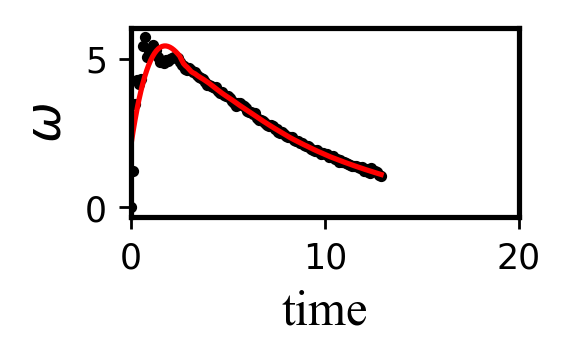

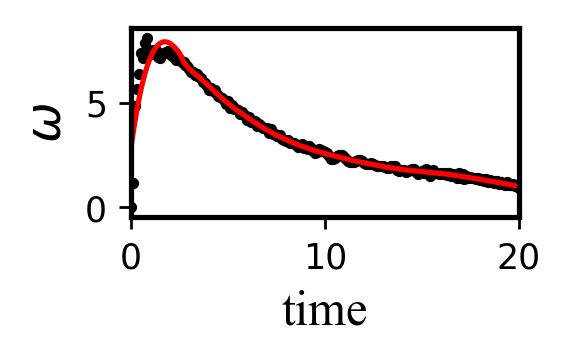

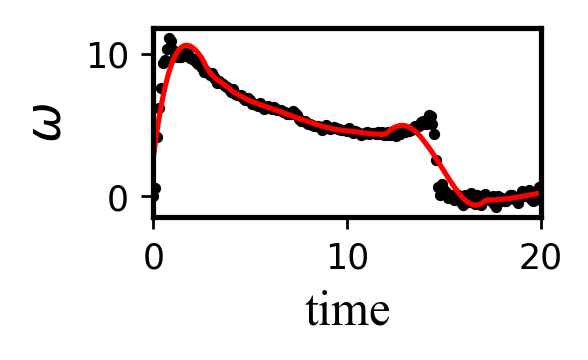

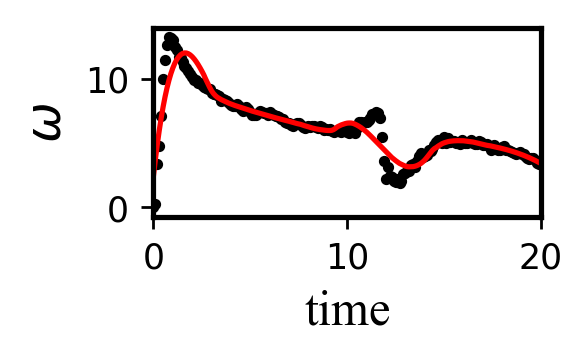

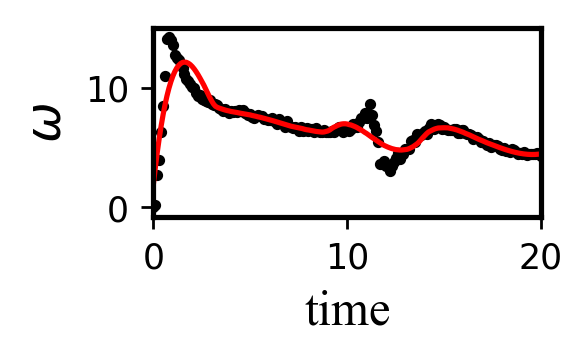

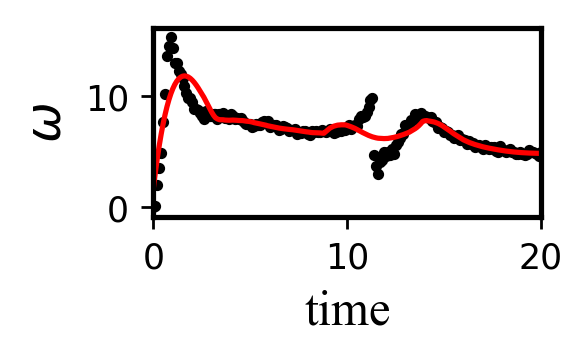

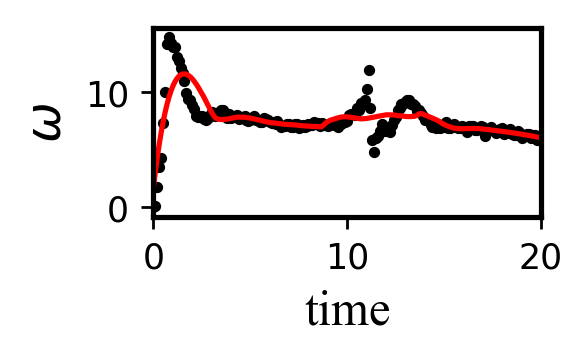

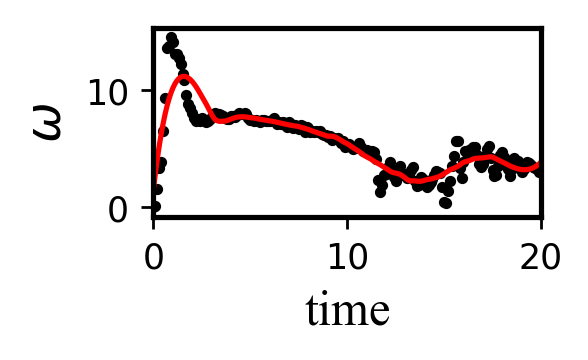

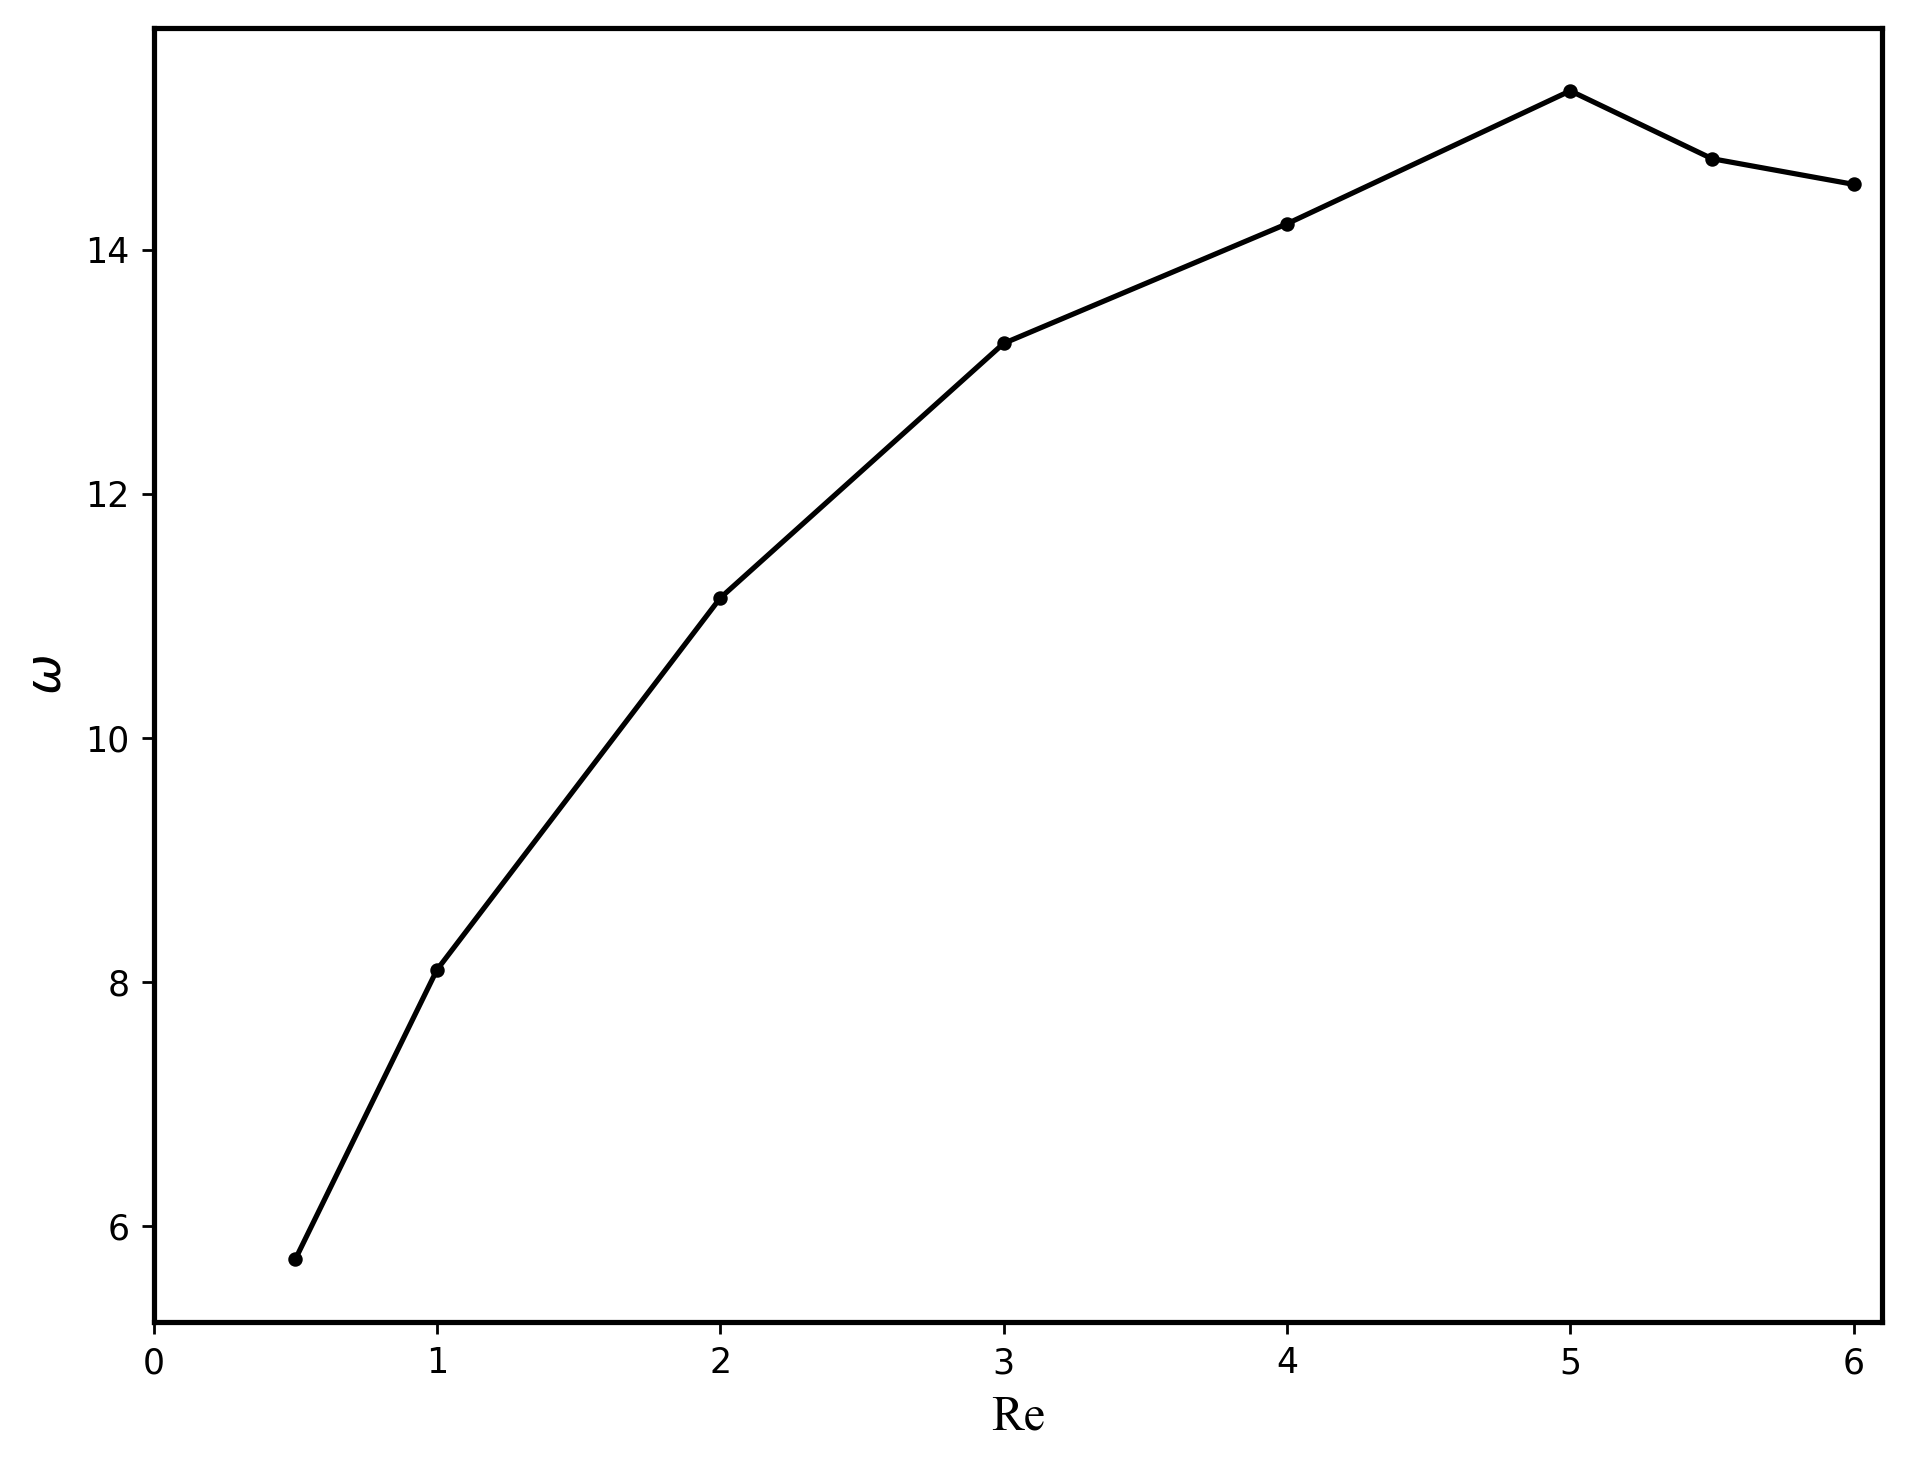

In [11]:
#Calculate maximum omega values for diverging spiralsz; Re < 6.5
#1) Get omega data vs. time
#2) smooth omega data vs. time
#3) find maximum of smoothed curve
#4) plot maximum vs. Re

def SmoothCurve(data,varName):
    #After plotting the raw data for forces, the term mdu/dt was very noisy
    #We will apply a smoothing algorithm to all velocities in the y-direction
    
    #Use Savitsky-Golay filter from scipy
    yval = data[varName].tolist()
    varValue = savgol_filter(yval, 51, 3)
    
    return varValue

SpiralReList = ['0.5','1.0','2.0','3.0','4.0','5.0','5.5','6.0']
spiralRe = [float(a) for a in SpiralReList]
maxOmega = np.zeros(len(spiralRe))
maxSmooth = np.zeros(len(spiralRe))

#1) Get omega data vs. time
OData = pd.read_csv(cwd_PYTHON+'/OData.csv',delimiter=' ')
count = 0
for Re in spiralRe:
    ReData = OData[OData['Re'] == Re].copy()
    ReData['smoothW'] = SmoothCurve(ReData,'wAVG')
    #Plot smooth vs raw to make sure it is correct
    fig, ax = plt.subplots(nrows=1,ncols=1,num=5,figsize=(2,1),dpi=250)
    #ax.set_title(r'$\hat{h}$ vs. Re',fontsize=18,**csfont)
    ax.set_xlabel(r'time',fontsize=14,**csfont)
    ax.set_ylabel(r'$\omega$',fontsize=14,**csfont)
    ax.plot(ReData['time'],ReData['smoothW'],color='r')
    ax.scatter(ReData['time'],ReData['wAVG'],color='k',s=5)
    ax.set_xlim(0.0,20.0)
    plt.show()
    fig.clf()
    #Get maximum value of omega
    maxOmega[count] = np.amax(ReData['wAVG'])
    maxSmooth[count] = np.amax(ReData['smoothW'])
    count += 1
    
fig, ax = plt.subplots(nrows=1,ncols=1,num=5,figsize=(4,3),dpi=250)
#ax.set_title(r'$\hat{h}$ vs. Re',fontsize=18,**csfont)
ax.set_xlabel(r'Re',fontsize=14,**csfont)
ax.set_ylabel(r'$\omega$',fontsize=14,**csfont)
ax.plot(spiralRe,maxOmega,color='k')
ax.scatter(spiralRe,maxOmega,color='k',s=10)
ax.set_xlim(0.0,6.1)
ax = set_size(6,4.5,ax)
fig.tight_layout()
plt.show()
pathlib.Path(cwd_PYTHON+'/../Figures/Omega').mkdir(parents=True, exist_ok=True)
fig.savefig(cwd_PYTHON+'/../Figures/Omega/spiralMaxOmega.png')
fig.clf()
plt.close()
    
    


In [18]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
    return ax

colorV = (117.0/255.0,112.0/255.0,179.0/255.0)
colorO = (231.0/255.0,41.0/255.0,138.0/255.0)
colorSF = (27.0/255.0,158.0/255.0,119.0/255.0)
colorHB = (217.0/255.0,95.0/255.0,2.0/255.0)

#Compare v_comb to single swimmer velocity
cwd_Single = cwd_PYTHON+'/'
singleData = pd.read_csv(cwd_Single+'SingleSwimmer_VelData_new.csv',delimiter=',')
singleData = singleData[singleData['Re'] <= 50.0].copy()
#singleData['v_avg'] = singleData['v_avg']
singleData = singleData.reset_index(drop=True)
#Plot Both v_comb and v_single on same axes
fig, ax = plt.subplots(nrows=1,ncols=1,num=1,figsize=(8,6),dpi=250)
#ax.set_title(r'$v_{avg}$ vs. Re: Pair vs. Single',fontsize=15,**csfont)
ax.set_xlabel(r'Re',fontsize=25,**csfont)
#ax.set_xlabel(r'$\delta$ (m)',fontsize=12,**csfont)
ax.set_ylabel(r'$\langle v \rangle/$Rf',fontsize=25,**csfont)


#Inset location
#left, bottom, width, height = [0.2125,0.65,0.3,0.3] #Re_s
left, bottom, width, height = [0.615,0.16,0.25,0.25] #Re_s
axSemiLog = fig.add_axes([left,bottom,width,height])


ax2 = ax.twinx()
ax2.set_ylabel(r'$\langle \Omega \rangle$',fontsize=25,**csfont,color=colorO)

ax.plot([0.0,65.0],[0.0,0.0] ,color='k')
#V-Shape
VRe = [float(a) for a in VReList]
ax.plot(VRe, Vcomb_V[:,0],color=colorV,label='In-tandem V')
ax.scatter(VRe, Vcomb_V[:,0],color=colorV,s=54,label=None)
#Single File (In-Line)
SFRe = [float(a) for a in SFReList]
ax.plot(SFRe, Vcomb_SF[:,0],color=colorSF,label='Parallel in-line')
ax.scatter(SFRe, Vcomb_SF[:,0],color=colorSF,s=54,label=None)
#Single Bot
ax.plot(singleData['Re'],singleData['v_avg'],color='k',label='Single swimmer')
ax.scatter(singleData['Re'],singleData['v_avg'],color='k',s=54,label=None)
ax.axis([0.0,55.0,-0.19,0.325])
#ax.legend(loc='upper left',fontsize='large')
#Axes Parameters
ax.tick_params(which='major',axis='both',direction='in',length=14,width=1,zorder=10)
ax.tick_params(which='minor',axis='both',direction='in',length=8,width=0.75)
#ax.set_axisbelow(False)
#ax.set_xticks(np.arange(0.0,1.1,step=0.2))
ax.xaxis.set_major_locator(MultipleLocator(10.0))
ax.xaxis.set_minor_locator(MultipleLocator(2.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.025))
# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)



#Inset
axSemiLog.plot([0.0,65.0],[0.0,0.0] ,color='k')
axSemiLog.plot(VRe, Vcomb_V[:,0],color=colorV,label=None)
axSemiLog.scatter(VRe, Vcomb_V[:,0],color=colorV,s=24,label=None)
axSemiLog.plot(SFRe, Vcomb_SF[:,0],color=colorSF,label=None)
axSemiLog.scatter(SFRe, Vcomb_SF[:,0],color=colorSF,s=24,label=None)
axSemiLog.plot(singleData['Re'],singleData['v_avg'],color='k',label=None)
axSemiLog.scatter(singleData['Re'],singleData['v_avg'],color='k',s=24,label=None)
axSemiLog.set_xscale('log')
axSemiLog.axis([0.4,12.6,-0.1,0.01])
#Axes Parameters
axSemiLog.tick_params(which='major',axis='both',direction='in',length=10,width=1,zorder=10)
axSemiLog.tick_params(which='minor',axis='both',direction='in',length=6,width=0.75)
axSemiLog.yaxis.set_major_locator(MultipleLocator(0.05))
axSemiLog.yaxis.set_minor_locator(MultipleLocator(0.025))
# Set tick font size
for label in (axSemiLog.get_xticklabels() + axSemiLog.get_yticklabels()):
    label.set_fontsize(15)

    
#Orbit
ORe = [float(a) for a in OReList]
#ax2.plot([0.0,65.0],[0.0,0.0] ,color='k',ls='--')
ax2.plot(ORe, abs(omega_O[:,0]),color=colorO,label='In-tandem Orbit')
ax2.scatter(ORe, abs(omega_O[:,0]),color=colorO,s=54,label=None,marker="s")
ax2.plot(spiralRe,-1.0*maxOmega,color=colorO,label='In-tandem Spiral')
ax2.scatter(spiralRe, -1.0*maxOmega,color=colorO,s=54,label=None,marker="s",facecolor='none')
#ax2.legend(loc='lower right',fontsize='large')
#ax2.set_ylim(-100.0,170.0)
ax2.set_ylim(-59.0,100.0)
ax2.tick_params(which='major',labelcolor=colorO)
ax2.tick_params(which='minor',labelcolor=colorO)
ax2.tick_params(which='major',axis='both',direction='in',length=14,width=1,zorder=10)
ax2.tick_params(which='minor',axis='both',direction='in',length=8,width=0.7)
ax2.yaxis.set_minor_locator(MultipleLocator(5))
# Set tick font size
for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontsize(20)
ax.xaxis.set_ticks_position('both')
    
ax = set_size(8,6,ax)
ax2 = set_size(8,6,ax2)

fig.tight_layout()
pathlib.Path(cwd_PYTHON+'/../Figures/Velocities/').mkdir(parents=True, exist_ok=True)
fig.savefig(cwd_PYTHON+'/../Figures/Velocities/CompareVel_SinglePair_omegapos_spiral_3.png')
#fig.savefig(cwd_PYTHON+'/../Figures/Velocities/CompareVel_SinglePair_omegapos_spiral_2.svg')
fig.savefig(cwd_PYTHON+'/../Figures/Velocities/CompareVel_SinglePair_omegapos_spiral_3.svg')
fig.clf()
plt.close()
print('Plotting Pair vs. Single Velocities is complete')

Plotting Pair vs. Single Velocities is complete


Power Law: $Re$ exponent
N =  10
exponent = -4.156
intercept = -1.768
r_value = -0.931
----------------------------------------


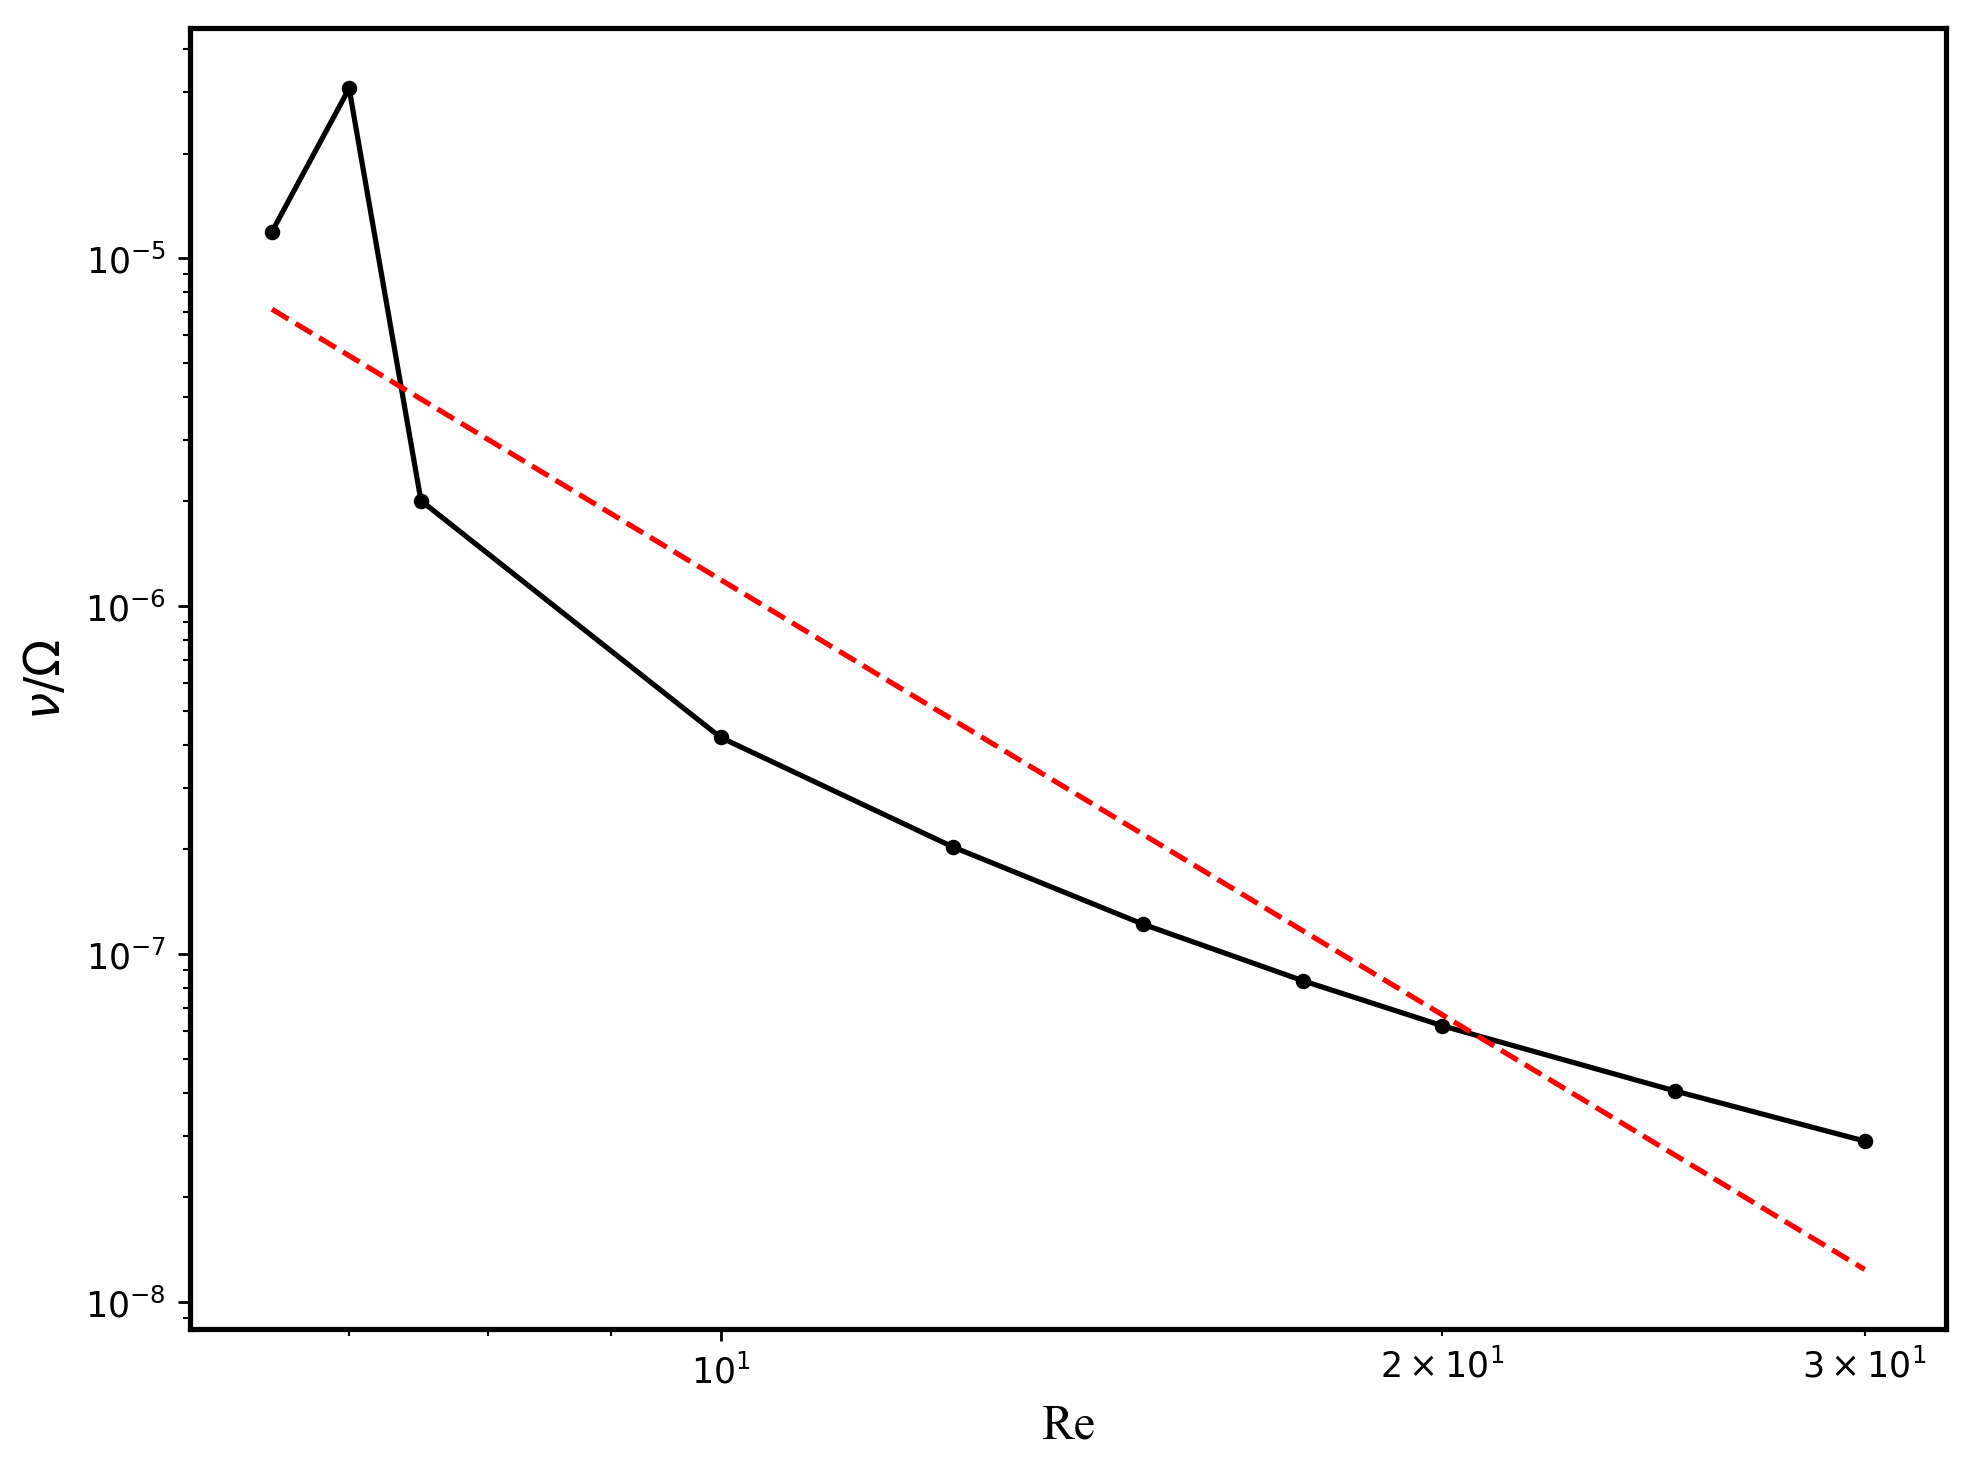

In [67]:
#Orbit: Plot Nu/Omega vs. Re?
#Nu = A_r*r*omega/Re
A_r = RADIUSLARGE*0.8*0.8
omega = 2.0*np.pi*FREQUENCY
Nu = [A_r*RADIUSSMALL*omega/Re for Re in ORe]
lengthScale = abs(Nu/omega_O[:,0])

slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(ORe),np.log10(lengthScale))
yFit = 10.0**(intercept)*ORe**slope
print("="*40)
print(r'Power Law: $Re$ exponent')
print('N = ',len(ORe))
print('exponent = %.3f'%slope)
print('intercept = %.3f'%intercept)
print('r_value = %.3f'%r_value)
print("-"*40)

fig, ax = plt.subplots(nrows=1,ncols=1,num=1,figsize=(8,6),dpi=250)
ax.set_xlabel(r'Re',fontsize=14,**csfont)
ax.set_ylabel(r'$\nu/\Omega$',fontsize=14,**csfont)
ax.loglog(ORe,lengthScale,c='k')
ax.scatter(ORe,lengthScale,c='k',s=12)
ax.plot(ORe,yFit,ls='--',c='r')
fig.tight_layout()
plt.show()

Re_single =  [0.5 0.6 0.7 0.8 0.9 1.  2.  3.  4.  5.  5.5 6.  6.5 7.  7.5]
U_single =  [-0.05419252 -0.05885768 -0.06255706 -0.06488558 -0.0674146  -0.06941563
 -0.07259853 -0.06657845 -0.05924701 -0.05300298 -0.05110749 -0.05192101
 -0.04575124 -0.04950668 -0.04599579]
Re_SF =  [0.5 0.6 0.7 0.8 0.9 1.  2.  3.  4.  5.  5.5 6.  6.5 7.  7.5]
U_SF =  [-0.04520733 -0.04777484 -0.04988556 -0.05162336 -0.05237848 -0.05309653
 -0.05157176 -0.04632506 -0.04235677 -0.03670468 -0.03569375 -0.03337591
 -0.03147261 -0.02861593 -0.02492614]


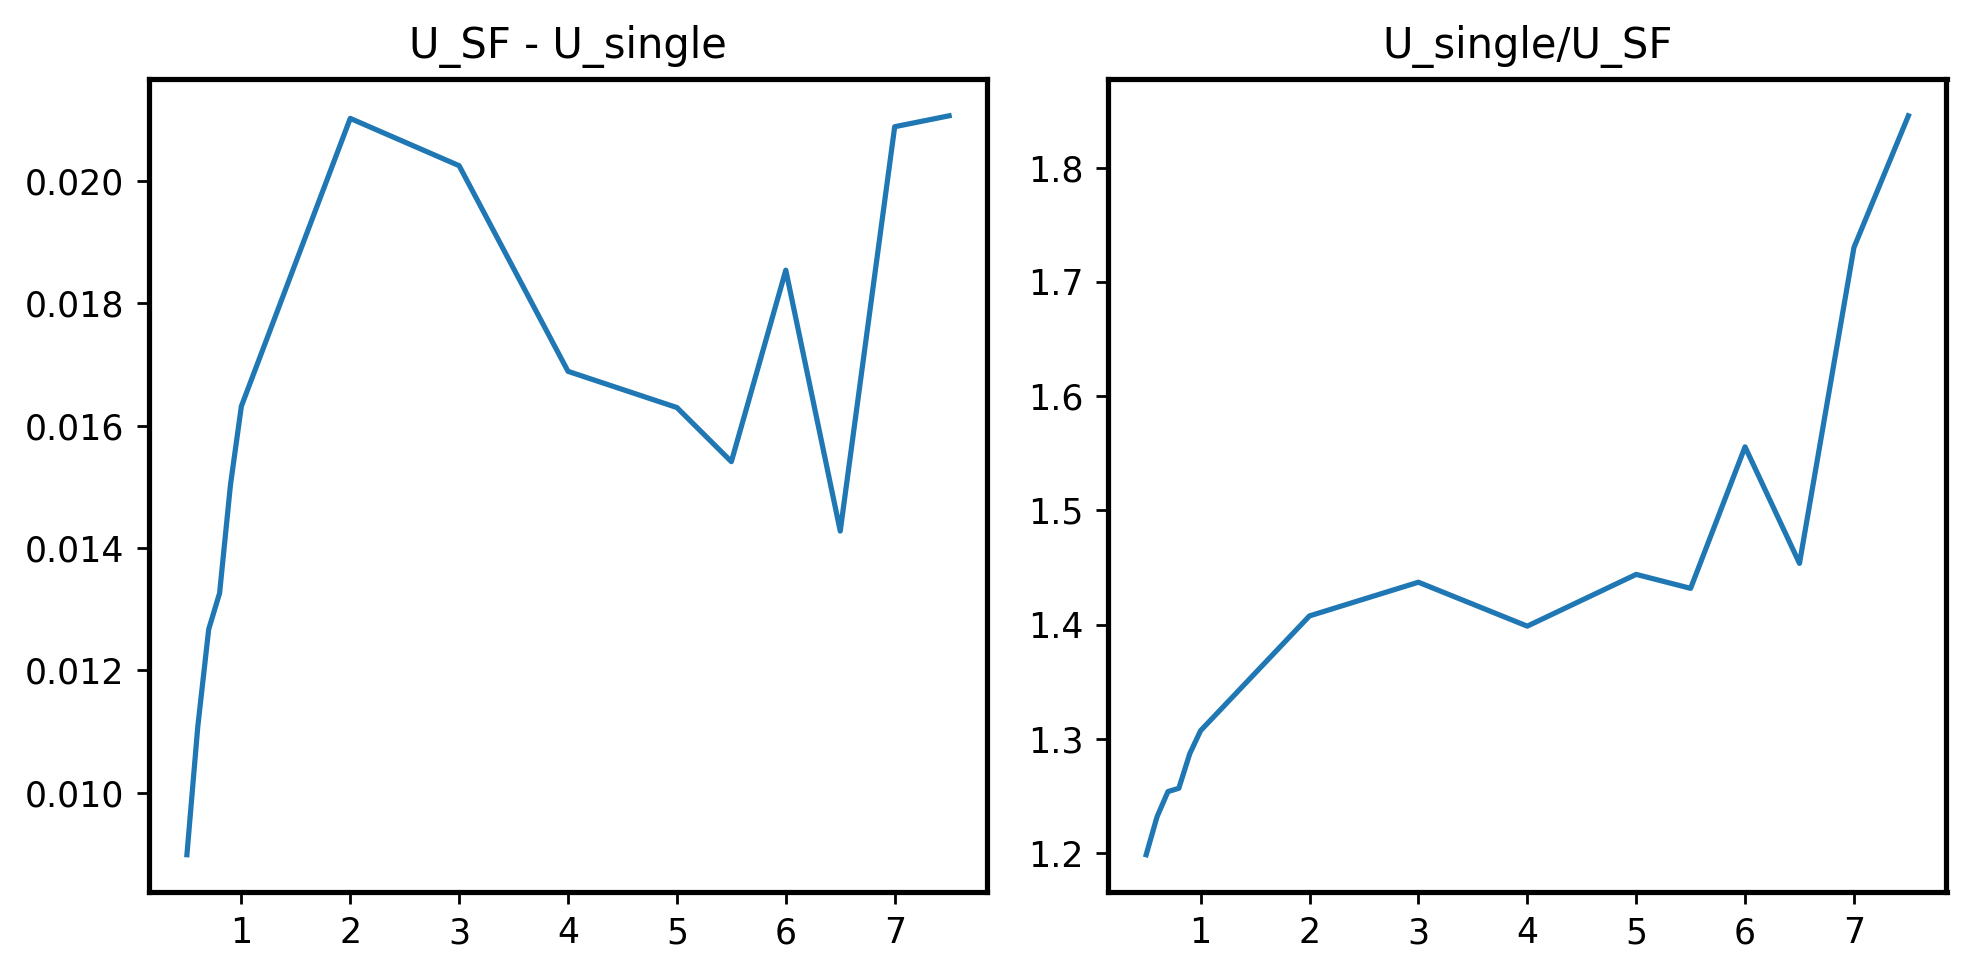

In [8]:
#Calculate and Plot (Difference and Ratio) of (U_single and U_SF)
#Single
cwd_Single = cwd_PYTHON+'/'
singleData = pd.read_csv(cwd_Single+'SingleSwimmer_VelData_new.csv',delimiter=',')
singleData = singleData[singleData['Re'] <= 7.5].copy()
#singleData['v_avg'] = singleData['v_avg']
singleData = singleData.reset_index(drop=True)
Re_single = np.array(singleData['Re'].values.tolist())
U_single = np.array(singleData['v_avg'].values.tolist())
print('Re_single = ',Re_single)
print('U_single = ',U_single)
#SF
U_SF = Vcomb_SF[:,0].copy()
Re_SF = np.array([float(a) for a in SFReList])
print('Re_SF = ',Re_SF)
print('U_SF = ',U_SF)

#Calculate diff and ratio
U_diff = U_SF - U_single
U_rat = U_SF/U_single

fig, ax = plt.subplots(nrows=1,ncols=2,num=1,figsize=(8,4),dpi=250)
ax[0].set_title('U_SF - U_single')
ax[1].set_title('U_single/U_SF')
ax[0].plot(Re_single,U_diff)
ax[1].plot(Re_single,1.0/U_rat)
fig.tight_layout()
plt.show()
